In [ ]:
!pip install -q transformers sentencepiece

     |████████████████████████████████| 4.0 MB 4.1 MB/s 
     |████████████████████████████████| 1.2 MB 49.4 MB/s 
     |████████████████████████████████| 596 kB 50.3 MB/s 
     |████████████████████████████████| 895 kB 51.0 MB/s 
     |████████████████████████████████| 6.5 MB 32.9 MB/s 
     |████████████████████████████████| 77 kB 7.1 MB/s 


In [ ]:
!pip install -q datasets jiwer

     |████████████████████████████████| 325 kB 4.1 MB/s 
     |████████████████████████████████| 212 kB 35.3 MB/s 
     |████████████████████████████████| 136 kB 52.6 MB/s 
     |████████████████████████████████| 1.1 MB 33.7 MB/s 
     |████████████████████████████████| 127 kB 30.9 MB/s 
     |████████████████████████████████| 50 kB 6.2 MB/s 
     |████████████████████████████████| 94 kB 1.8 MB/s 
     |████████████████████████████████| 144 kB 48.1 MB/s 
     |████████████████████████████████| 271 kB 38.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


## Prepare data

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# %cd /content/drive/MyDrive/projects/arabic_calligraphy/notebooks

In [10]:
import pandas as pd
import glob
import os
data_path = "../data/calliar/chars/"
images = glob.glob(os.path.join(data_path, '*'))[:3000]
df = pd.DataFrame(images, columns=["file_name"])
# df['text'] = df['file_name'].apply(lambda x: x.split("/")[-1].split("\uf03a")[-1][:-4]) # ":"
df['text'] = df['file_name'].apply(lambda x: x.split("/")[-1].split(":")[-1][:-4]) 
df

,file_name,text
0,../data/calliar/chars/ اقرا_0_0:ا.png,ا
1,../data/calliar/chars/ اقرا_0_1:ق.png,ق
2,../data/calliar/chars/ اقرا_0_2:ر.png,ر
3,../data/calliar/chars/ اقرا_0_3:ا.png,ا
4,../data/calliar/chars/ د يحيى بن محمد الخبراني...,د
...,...,...
2995,../data/calliar/chars/الا بذكر الله تطمئن القل...,ذ
2996,../data/calliar/chars/الا بذكر الله تطمئن القل...,ك
2997,../data/calliar/chars/الا بذكر الله تطمئن القل...,ر
2998,../data/calliar/chars/الا بذكر الله تطمئن القل...,ا


In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.1)
train_df, test_df = train_df[:2000], test_df[:10]
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
print(f"train_df: {train_df.shape}")
print(f"test_df: {test_df.shape}")

train_df: (2000, 2)
test_df: (10, 2)


In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class IAMDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text 
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text, 
                                          padding="max_length", 
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [ ]:
from transformers import TrOCRProcessor

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-small-stage1")
train_dataset = IAMDataset(root_dir=data_path,
                           df=train_df,
                           processor=processor)
eval_dataset = IAMDataset(root_dir=data_path,
                           df=test_df,
                           processor=processor)

In [ ]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 2000
Number of validation examples: 10


In [ ]:
encoding = train_dataset[0]
for k,v in encoding.items():
  print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([128])


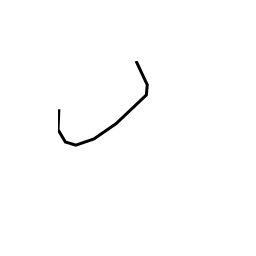

In [ ]:
image = Image.open(train_df['file_name'][0]).convert("RGB")
image

In [ ]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

ر


## Train a model

In [2]:
from transformers import VisionEncoderDecoderModel

model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-small-stage1")

In [ ]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 1 # 4

In [ ]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    fp16=True, 
    output_dir="./",
    logging_steps=2,
    save_steps=1000,
    save_total_limit=1,
    eval_steps=10,
    num_train_epochs=1000,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
from datasets import load_metric

cer_metric = load_metric("cer")

In [ ]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)
    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

In [ ]:
from transformers import default_data_collator

# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)
trainer.train()

Using amp half precision backend
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 2000
  Num Epochs = 1000
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 250000


Step,Training Loss,Validation Loss,Cer
10,4.256500,4.173011,1.000000
20,2.913900,2.420579,2.600000
30,2.309400,1.719594,0.700000
40,2.544100,1.738396,0.600000
50,2.340200,1.394623,0.800000
60,1.502500,1.462790,0.900000
70,1.315400,1.207686,0.800000
80,1.495700,1.169973,0.600000
90,1.392400,1.210621,0.900000
100,1.585400,1.233536,0.600000


***** Running Evaluation *****
  Num examples = 10
  Batch size = 8
***** Running Evaluation *****
  Num examples = 10
  Batch size = 8
***** Running Evaluation *****
  Num examples = 10
  Batch size = 8
***** Running Evaluation *****
  Num examples = 10
  Batch size = 8
***** Running Evaluation *****
  Num examples = 10
  Batch size = 8
***** Running Evaluation *****
  Num examples = 10
  Batch size = 8
***** Running Evaluation *****
  Num examples = 10
  Batch size = 8
***** Running Evaluation *****
  Num examples = 10
  Batch size = 8
***** Running Evaluation *****
  Num examples = 10
  Batch size = 8
***** Running Evaluation *****
  Num examples = 10
  Batch size = 8
***** Running Evaluation *****
  Num examples = 10
  Batch size = 8
***** Running Evaluation *****
  Num examples = 10
  Batch size = 8
***** Running Evaluation *****
  Num examples = 10
  Batch size = 8
***** Running Evaluation *****
  Num examples = 10
  Batch size = 8
***** Running Evaluation *****
  Num examples = 